## Multi Agent System

In [1]:
import os
from langchain_community.tools import DuckDuckGoSearchRun
from typing_extensions import Annotated
from dotenv import load_dotenv

load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', '')

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')

In [2]:
llm.invoke('Hey, how are you')

AIMessage(content="Hello! I'm just a computer program, so I don't have feelings, but I'm here to help you. How can I assist you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 12, 'total_tokens': 40, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BlPb6HNpidPKAKEz9xXKiqoH4RObq', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6272ba0d-f802-4326-8a0a-263d4879b670-0', usage_metadata={'input_tokens': 12, 'output_tokens': 28, 'total_tokens': 40, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [3]:
search_tool = DuckDuckGoSearchRun()

In [4]:
search_tool.run('Who is the current prime minister of UK?')

'What to know about Keir Starmer, UK\'s new prime minister by Yash Roy - 07/06/24 10:42 AM ET. by Yash Roy - 07/06/24 10:42 AM ET. ... During his first speech as prime minister, he promised that ... Mr Starmer has been leader of the Labour party since 2020 and is the country\'s 58th prime minister. He was born in 1962. His dad was a toolmaker in a factory and his mum was a nurse in the NHS. Prime Minister Sir Keir Starmer — the former lawyer was knighted for services to criminal justice — has, through years of chaos (you may remember Partygate, or perhaps even Prime Minister Liz ... Sunak was the United Kingdom\'s first British Indian prime minister and its first Hindu leader. At 42, he was the youngest prime minister to take the job in over 200 years. The soon-to-be new UK Prime Minister Keir Starmer has addressed cheering supporters at a Labour Party victory rally in central London, and pledged "national renewal" following 14 years of ...'

In [5]:
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool

In [6]:
repl = PythonREPL()

In [7]:
@tool
def python_repl_tool(
        code: Annotated[str, "The python code to execute to generate your chart."]
):
    """Use this to execute python code. If you want to see the output of a value, you should print it out with `print(...)`. This is visible to the user."""

    try:
        result = repl.run(code)
        result_str = f"successfully executed:\n```python\n{code}\n```\nStdout: {result}"

        return (result_str + "\n\nIf you have completed all the tasks, respond with FINAL ANSWER.")
    except BaseException as e:
        return f"Failed to execute. Errir: {repl(e)}"

In [8]:
code = """
x = 5
y = x * 2
print(y)
"""

repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [9]:
python_repl_tool

StructuredTool(name='python_repl_tool', description='Use this to execute python code. If you want to see the output of a value, you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x0000021DA92D7880>)

In [10]:
print(python_repl_tool.invoke(code))

successfully executed:
```python

x = 5
y = x * 2
print(y)

```
Stdout: 10


If you have completed all the tasks, respond with FINAL ANSWER.


In [11]:
from langgraph.graph import MessagesState, StateGraph
from langgraph.graph import END, START
from langgraph.types import Command
from typing_extensions import Literal
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import BaseMessage, HumanMessage

In [21]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [20]:
make_system_prompt("You can only do research. You are working with a chart generator colleague.")

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [22]:
from typing import Literal
from langgraph.graph import MessagesState 

#agent1
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    research_agent=create_react_agent(
        llm,
        tools=[search_tool],
        prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ), 
        )
    
    result=research_agent.invoke(state)
    goto=get_next_node(result["messages"][-1],"chart_generator")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)

### Agent 2

In [23]:
#agent2
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    chart_agent=create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
        )
    result=chart_agent.invoke(state)
    goto=get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    return Command(update={"messages": result["messages"]},goto=goto)

In [24]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

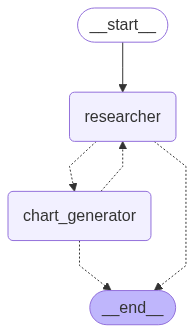

In [25]:
workflow.compile()

In [29]:
app.invoke({'messages': [('user', "get the UK's GDP over the last 3 years. Then make a line chart of it. Once you are done with the line chart, finish.")]})

{'messages': [HumanMessage(content="get the UK's GDP over the last 3 years. Then make a line chart of it. Once you are done with the line chart, finish.", additional_kwargs={}, response_metadata={}, id='54590033-afd4-4fb4-8a90-812b579df870'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Wu4h0pkQVZRC3mclEPkt5xzR', 'function': {'arguments': '{"query":"UK GDP last 3 years"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 203, 'total_tokens': 225, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BlPyv5bS3ZMU5WyQbodTgwr3ry3VQ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b07517f6-3b

In [1]:
# Code sent to the python_repl_tool
import matplotlib.pyplot as plt

years = [2021, 2022, 2023]
growth_rates = [8.7, 4.3, 0.1]

plt.figure(figsize=(8, 5))
plt.plot(years, growth_rates, marker='o')
plt.title("UK GDP Growth Rates (2021-2023)")
plt.xlabel("Year")
plt.ylabel("GDP Growth Rate (%)")
plt.grid(True)
plt.xticks(years)
plt.show()


ModuleNotFoundError: No module named 'matplotlib'